# Intelligent Image Gallery with Uploads, Deduplication, and Text-Based Search Using Vector DB Qdrant and Sentence Transformers.

Smart Image Gallery powered by AI. That can perform the following Tasks:
- Search your images using just Text. (Ex: "Smiling group photos", "Surfing", "Exam Notes", etc.,.)
- Image Deduplication

1. ```Dataset``` : Currently testing out with an open-source dataset called cats_vs_dogs from HuggingFace.  
Dataset : [cats_vs_dogs](https://huggingface.co/datasets/microsoft/cats_vs_dogs) contains about 23,422 images of dogs and cats.

2. ```Qdrant``` : Qdrant is a lightweight vector database that recently started their managed cloud services, which let you use a free cluster for trial and the option to upgrade as you use more features. We will use it to store our dataset in the form of vectors.

3. ```CLIP``` : CLIP is a text and image encoder model that generates embeddings for both text and images! We need a vector representation of images to store them in the Qdrant collection. [CLIP](https://openai.com/research/clip)

4. ```Gradio``` : User interface built using the open-source demo platform Gradio.

## 1. Setup

In [1]:
# %%capture
!pip install qdrant-client datasets sentence-transformers gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.3/229.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 13.9 MB/s eta 0:00:00
  Preparing metadata

## 2. Import Necessary Libraries

In [2]:
from qdrant_client import models, QdrantClient
from qdrant_client.models import PointStruct
from sentence_transformers import SentenceTransformer, util
import torch
from datasets import load_dataset, DatasetDict
import gradio as gr
from PIL import Image

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Access CUDA if environment has GPU support and build with CUDA

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## 3. Import Datasets

.shuffle() to randomize data and take a sample out of it

In [4]:
dataset = load_dataset("cats_vs_dogs",verification_mode='no_checks').shuffle()

The repository for cats_vs_dogs contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/cats_vs_dogs.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/23410 [00:00<?, ? examples/s]

In [5]:
dataset.shape

{'train': (23410, 2)}

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 23410
    })
})

23,410 is a lot of images and not efficient to store lot of data under Qdrant Free Tier. We can test out with a sample of 100 images.

In [7]:
small_dataset = dataset['train'][:100]

Output of a row of data

In [8]:
print(small_dataset['image'][0], small_dataset['labels'][0])

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x7D0B39288640> 0


PIL Object is nothing but an image, we can print and check for different labels

In [9]:
small_dataset['image'][0].show()

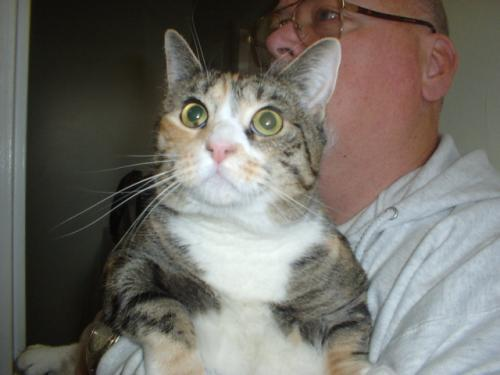

In [10]:
small_dataset['image'][0]

## 4. Initialize Qdrant Client

In [11]:
qdrant = QdrantClient(":memory:")
# qdrant = QdrantClient(path="path/to/db")

## 5. Create a Qdrant Collection

In [12]:
coll_name = "catsanddogs"
embed_size = 1024

In [13]:
qdrant.recreate_collection(
            collection_name=coll_name,
            vectors_config=models.VectorParams(
            size=embed_size,  # Vector size is defined by used model
            distance=models.Distance.COSINE,
        ),)

<ipython-input-13-9f6067e9bd87>:1: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  qdrant.recreate_collection(


True

Note:  
- Your collection_name should remain the same across the code since that is the basis of Qdrant.
- Size is the embedding vector size of your embedding model.
- Distance is a metric used to compare the vectors. There are others as well but for similarity search, we go with Cosine similarity.

To insert Data points to the collection :

In [ ]:
qdrant.upsert(
            collection_name=coll_name,
            points=[
                PointStruct(
                  id=idx,
                  vector=vector.tolist(),
                  payload={"label": self.df['labels'][idx] , "animal": idx}
                )
                 for idx, vector in enumerate(vectors)
            ]
)

## 6. Convert Images to Vectors : CLIP Embedding

We need a vector representation of images to store them in the collection. In this experiment, we will use a model named ```clip-ViT-B-32``` which is a text and image encoder model that generates embeddings for both text and images

In [15]:
encoder = SentenceTransformer('clip-ViT-B-32', device=device)
encoder.encode("Three dogs running together").shape

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

0_CLIPModel/special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

0_CLIPModel/tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

0_CLIPModel/vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

0_CLIPModel/preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

0_CLIPModel/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

0_CLIPModel/config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

(512,)

We get (512,) which means the generated embeddings have a size of 512 — basically, for each example we have 512 real numbers, which make up one vector.

In [16]:
encoder.encode(small_dataset['image'][10])

array([-4.57145125e-02,  2.96818733e-01, -3.68761837e-01,  6.97134435e-01,
        1.90932065e-01, -2.27413267e-01,  4.25302207e-01,  2.21957058e-01,
        6.92267835e-01,  3.69113147e-01, -1.14548802e-02, -3.74899060e-02,
        3.31914216e-01,  3.53812665e-01,  2.48155832e-01,  5.22021592e-01,
        1.33130682e+00,  1.78612664e-01, -1.26336470e-01, -3.35406184e-01,
       -1.24067426e-01,  8.46879408e-02,  5.07239103e-01, -6.17636964e-02,
       -3.27380359e-01,  2.79068172e-01,  2.68460393e-01,  2.76582628e-01,
        1.19880140e-02, -3.67012531e-01,  7.72992969e-02,  2.75258183e-01,
       -1.67907029e-01, -3.42336655e-01,  3.55510890e-01, -2.06038058e-01,
        1.46730274e-01, -2.83984095e-01, -6.26745462e-01,  1.41343307e+00,
       -2.89405912e-01,  1.81389928e-01,  2.84906566e-01, -1.01706684e-01,
        3.24159831e-01,  1.41834617e-01,  2.20620945e-01, -1.29200220e-02,
       -1.43086120e-01, -2.07668632e-01, -2.74392366e-01,  1.12011850e-01,
       -3.34936202e-01,  

## 7. Bundle Qdrant Operations : QdrantOps (Class)

1. Create_collection: Used to create a new collection.
2. Batch_insert_new_images: Insert the vector representation of images all together in a batch, ideal for inserting the entire dataset.
3. Insert_single_image: Insert a vector representation of a single image in the collection.
4. Search: The function that gives you k-best matches for the query (image or search)
5. Encode_text_or_image: Returns embeddings for text or images using the “clip-ViT-B-32” model.

In [17]:
class QdrantOps:
    def __init__(self, collection_name):
        self.encoder = SentenceTransformer('clip-ViT-B-32', device=device)
        self.qdrant = QdrantClient(":memory:")
        self.df = small_dataset
        self.coll_name = collection_name
        self.create_collection(self.coll_name)
        self.batch_insert_new_images(self.df['image'])

    def create_collection(self, coll_name):
        self.qdrant.recreate_collection(
            collection_name=coll_name,
            vectors_config=models.VectorParams(
            size=512,  # Vector size is defined by used model
            distance=models.Distance.COSINE,
        ),)

    def batch_insert_new_images(self, images):
        vectors = self.encoder.encode(images)
        self.qdrant.upsert(
            collection_name=self.coll_name,
            points=[
                PointStruct(
                    id=idx,
                    vector=vector.tolist(),
                    payload={"label": self.df['labels'][idx] , "animal": idx}
                )
                for idx, vector in enumerate(vectors)
            ]
        )
        print("inserted "+ str(len(vectors)) +" images in the collection.")

    def insert_single_image(self, input):
        self.df['image'].append(input)
        self.df['labels'].append("new") # optional, not needed
        idx =  self.df['image'].index(self.df['image'][-1])
        self.qdrant.upsert(collection_name=self.coll_name,points=[
            PointStruct(
                id=self.df['image'].index(small_dataset['image'][-1]),
                payload={"label": self.df['labels'][-1] , "animal": idx},
                vector=self.encode_text_or_image(input),
                ),
            ],
        )
        print(f"inserted 1 new image with index {idx} in the collection.")

    def search(self, query):
        hits = self.qdrant.search(collection_name=self.coll_name,
                                  query_vector=self.encode_text_or_image(query).tolist(),
                                  limit=3) # 3 best matches will be fetched)
        return hits

    def encode_text_or_image(self, inp):
        vec=self.encoder.encode(inp)
        return vec

Initialize the Qdrant client using this class

In [18]:
Qdrant_obj = QdrantOps(collection_name="cats_and_dogs")

<ipython-input-17-5dca7173ac1c>:11: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  self.qdrant.recreate_collection(


inserted 100 images in the collection.


## 9. IntelligentGallery (Class)  

1. Semantic_search: Used to fetch output images and scores using the search method from QdrantOps.
2. Output_when_image_input: This is used to return the matches when the input is an image and does two things:  
a) If the best match score is less than 0.95, we consider that the input is a new image and not a duplicate. This is purely experimental; you can set this threshold value as per your wish and the data.  
b) If the score is greater than 0.95, then we have a duplicate input image and we just return the original image (from which the input has been duplicated).
3. Output_when_text_input: Returns 3 best matches for the particular input text, and allows the user to search the image using text.
4. Gradio_ui: This is our user interface built using the open-source demo platform Gradio.  

Both the functions Output_when_image_input and Output_when_text_input also return the match scores, which will be seen in a status box in the search boxes.  
When you try to upload an already present image, you will get to see an image-based search, since the duplicate is removed and the function returns the best matches for the input.

In [19]:
class IntelligentGallery:
    def __init__(self,coll_name):
        self.qdrant_obj = QdrantOps(collection_name=coll_name)

    def semantic_search(self,input):
        msg = ""
        scores=[]
        outs=[]
        for hit in self.qdrant_obj.search(input):
            scores.append(hit.score)
            outs.append(self.qdrant_obj.df['image'][hit.payload['animal']])
        return outs, scores

    def output_when_image_input(self, input):
        outs, scores = self.semantic_search(input)
        if scores[0]<0.95:
            self.qdrant_obj.insert_single_image(input)
            outs = self.qdrant_obj.df['image']
            msg = "Adding new image to the gallery."
            return [outs, msg]
        else:
            msg = "Duplicate image already present so removing the new image." + f"Matches fetched with the scores: {scores}."
        return [outs, msg]

    def output_when_text_input(self,input):
        outs=[]
        scores=[]
        for hit in self.qdrant_obj.search(input):
            scores.append(hit.score)
            outs.append(self.qdrant_obj.df['image'][hit.payload['animal']])
        msg = f"Matches fetched with the scores: {scores}."
        return [outs, msg]

    def dummy(self,input):
        return self.qdrant_obj.df['image']

    def gradio_ui(self):
        with gr.Blocks() as demo:
            with gr.Tab("SMART GALLERY"):
                with gr.Row():
                    data = self.qdrant_obj.df['image']
                    gallery = gr.Gallery(value = data, show_label=False, elem_id="gallery",
                           columns=[6],
                           rows=[1],
                           object_fit="contain",
                           height="auto",
                           every=1)
                    btn2 = gr.Button(value="Reload Gallery", scale=0)
                    btn2.click(fn=self.dummy, outputs=gallery)
                with gr.Row():
                    btn = gr.Button(value="Search using text.", scale=0)
                    btn.click(fn=self.output_when_text_input, inputs=[gr.Textbox(label="Search for an image")],  outputs=[gallery,gr.Textbox(value="Status")]) #outputs=[tb1, match1, tb2, match2,tb3, match3])
                with gr.Row():
                    btn1 = gr.Button(value="Upload new image.", scale=0)
                    btn1.click(fn=self.output_when_image_input, inputs=[gr.Image(type="pil")], outputs=[gallery,gr.Textbox("Status")])
        demo.launch()

Start the Intelligent Image Gallery

In [20]:
int_gallery = IntelligentGallery("cats_and_dogs")
int_gallery.gradio_ui()

<ipython-input-17-5dca7173ac1c>:11: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  self.qdrant.recreate_collection(


inserted 100 images in the collection.


/usr/local/lib/python3.10/dist-packages/gradio/utils.py:1000: UserWarning: Expected 1 arguments for function <bound method IntelligentGallery.dummy of <__main__.IntelligentGallery object at 0x7d0b38132b30>>, received 0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/utils.py:1004: UserWarning: Expected at least 1 arguments for function <bound method IntelligentGallery.dummy of <__main__.IntelligentGallery object at 0x7d0b38132b30>>, received 0.
  warnings.warn(


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://5f573d7d9084b303c8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
